## Setup and import libraries

In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from itertools import combinations
from azure.storage.blob import BlobServiceClient
import config
from sklearn.preprocessing import PowerTransformer
from yellowbrick.cluster import KElbowVisualizer


In [2]:
connection_string = config.azure_blob_storage["connection_string"]
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
blob_client = blob_service_client.get_blob_client(container="datafactory", blob="input/data_1a1a465b-6bbb-4849-9ea1-20fc683f72e7_2b0601ce-91c5-45b5-bc20-67813544fe93.csv")

# Define the local path to save the file
local_file_path = "data_1a1a465b-6bbb-4849-9ea1-20fc683f72e7_2b0601ce-91c5-45b5-bc20-67813544fe93.csv"

# Download the blob and save it locally
with open(local_file_path, "wb") as file:
    file.write(blob_client.download_blob().readall())

In [10]:
df = pd.read_csv(local_file_path)
df.head()

,customer_id,customer_tenure,recency,total_orders_completed,total_sales_completed,total_sales,total_orders,returned_orders_ratio,cancelled_orders_ratio,customer_age,...,accessories,outerwear,shorts,fasion_hoodies,active,underwear,pants,socks,dresses,other
0,75990,457,844,1,19.990000,19.990000,1,0.0,0.0,35,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,77936,1,307,1,27.990000,27.990000,1,0.0,0.0,49,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0
2,86560,1,1595,2,108.200001,108.200001,1,0.0,0.0,46,...,0.0,0.0,0.0,0.0,0.399261,0.0,0.0,0.0,0.0,0.0
3,5671,360,164,1,59.990002,104.980003,2,0.0,0.5,21,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
4,4628,1,1667,1,195.300003,195.300003,1,0.0,0.0,61,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27575 entries, 0 to 27574
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             27575 non-null  int64  
 1   customer_tenure         27575 non-null  int64  
 2   recency                 27575 non-null  int64  
 3   total_orders_completed  27575 non-null  int64  
 4   total_sales_completed   27575 non-null  float64
 5   total_sales             27575 non-null  float64
 6   total_orders            27575 non-null  int64  
 7   returned_orders_ratio   27575 non-null  float64
 8   cancelled_orders_ratio  27575 non-null  float64
 9   customer_age            27575 non-null  int64  
 10  customer_gender         27575 non-null  object 
 11  state                   27575 non-null  object 
 12  city                    27272 non-null  object 
 13  country                 27575 non-null  object 
 14  total_cancels           22100 non-null

In [5]:
df.isna().sum()

customer_id                  0
customer_tenure              0
recency                      0
total_orders_completed       0
total_sales_completed        0
total_sales                  0
total_orders                 0
returned_orders_ratio        0
cancelled_orders_ratio       0
customer_age                 0
customer_gender              0
state                        0
city                       303
country                      0
total_cancels             5475
total_cart                5475
total_department          5475
total_home                5475
total_product             5475
total_purchases           5475
tops_and_tees                0
jeans                        0
intimates                    0
swim                         0
sweaters                     0
sleep                        0
accessories                  0
outerwear                    0
shorts                       0
fasion_hoodies               0
active                       0
underwear                    0
pants   

In [5]:
df.columns

Index(['customer_id', 'tops_and_tees', 'jeans', 'intimates', 'swim',
       'sweaters', 'sleep', 'accessories', 'outerwear', 'shorts',
       'fasion_hoodies', 'active', 'underwear', 'pants', 'socks', 'dresses',
       'other', 'total_orders_completed', 'total_sales_completed',
       'total_sales', 'total_orders', 'returned_orders_ratio',
       'cancelled_orders_ratio', 'recency', 'customer_age', 'customer_gender',
       'state', 'city', 'country'],
      dtype='object')

In [6]:
df['country'].unique()

array(['Brasil', 'United States', 'Japan', 'China', 'South Korea',
       'Spain', 'France', 'United Kingdom', 'Germany', 'Colombia',
       'Belgium', 'Poland', 'Australia', 'Deutschland'], dtype=object)

## Feature Engineering

In [7]:
#calc frequencies
location_frequency = df['country'].value_counts(normalize=True)

df['country_encoded'] = df['country'].map(location_frequency)

In [8]:
gender_dummies = pd.get_dummies(df['customer_gender'], prefix='gender', drop_first=True, dtype=int)
print(gender_dummies)

       gender_M
0             0
1             0
2             1
3             1
4             1
...         ...
27570         0
27571         1
27572         0
27573         1
27574         0

[27575 rows x 1 columns]


In [8]:

df = pd.concat([df, gender_dummies], axis=1)
df.head()

,customer_id,tops_and_tees,jeans,intimates,swim,sweaters,sleep,accessories,outerwear,shorts,...,returned_orders_ratio,cancelled_orders_ratio,recency,customer_age,customer_gender,state,city,country,country_encoded,gender_M
0,64370,0.0,0.0,0.0,0.0,0.000000,0.0,0.085616,0.547945,0.000000,...,0.0,1.0,713,41,M,Acre,Rio Branco,Brasil,0.144503,1
1,38519,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.000000,...,0.0,1.0,303,56,M,Acre,NaN,Brasil,0.144503,1
2,5059,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,1.0,476,39,F,Acre,Rio Branco,Brasil,0.144503,0
3,91493,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.495458,...,0.0,1.0,448,43,M,Acre,Tarauacá,Brasil,0.144503,1
4,40617,0.0,0.0,0.0,0.0,0.148225,0.0,0.000000,0.851775,0.000000,...,0.0,1.0,195,25,M,Acre,Rio Branco,Brasil,0.144503,1


In [9]:
df.columns

Index(['customer_id', 'tops_and_tees', 'jeans', 'intimates', 'swim',
       'sweaters', 'sleep', 'accessories', 'outerwear', 'shorts',
       'fasion_hoodies', 'active', 'underwear', 'pants', 'socks', 'dresses',
       'other', 'total_orders_completed', 'total_sales_completed',
       'total_sales', 'total_orders', 'returned_orders_ratio',
       'cancelled_orders_ratio', 'recency', 'customer_age', 'customer_gender',
       'state', 'city', 'country', 'country_encoded', 'gender_M'],
      dtype='object')

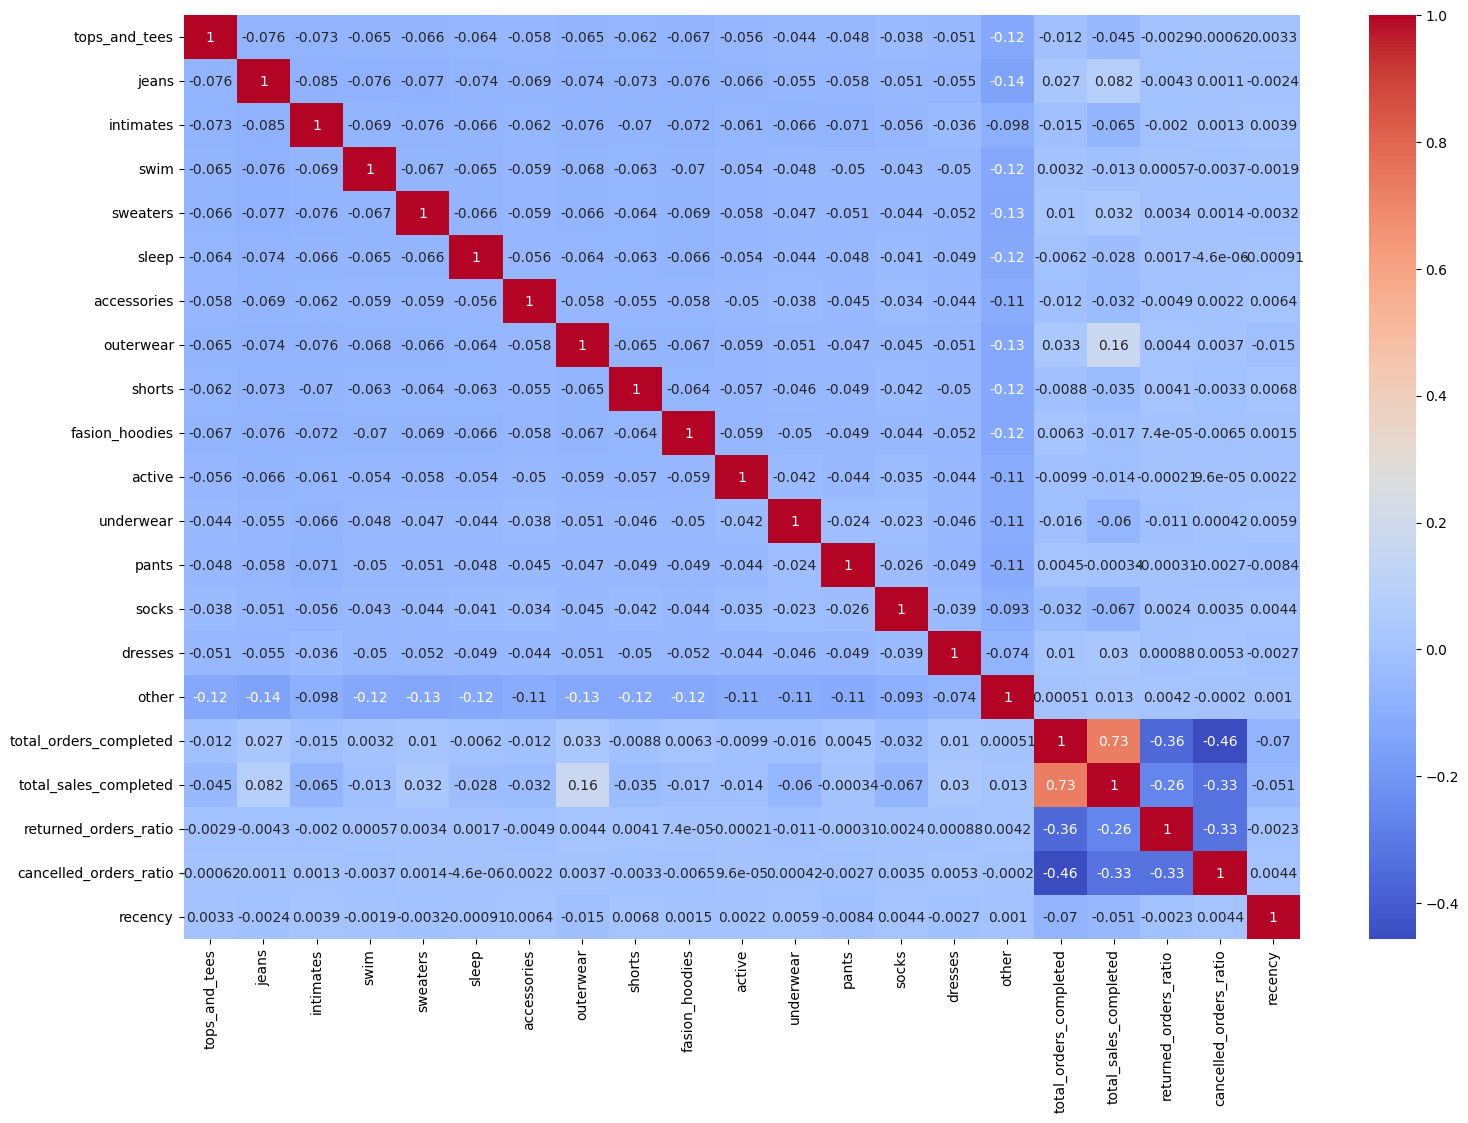

In [61]:
# features = ['tops_and_tees', 'jeans', 'intimates', 'swim',
#        'sweaters', 'sleep', 'accessories', 'outerwear', 'shorts',
#        'fasion_hoodies', 'active', 'underwear', 'pants', 'socks', 'dresses',
#        'other', 'total_orders_completed', 'total_sales_completed', 'returned_orders_ratio',
#        'cancelled_orders_ratio', 'recency']

df_num = df[features]

plt.figure(figsize=(18, 12))
#check for correlation between feaetures
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm')
plt.show()

In [12]:
df.head()

,customer_id,tops_and_tees,jeans,intimates,swim,sweaters,sleep,accessories,outerwear,shorts,...,returned_orders_ratio,cancelled_orders_ratio,recency,customer_age,customer_gender,state,city,country,country_encoded,gender_M
0,64370,0.0,0.0,0.0,0.0,0.000000,0.0,0.085616,0.547945,0.000000,...,0.0,1.0,713,41,M,Acre,Rio Branco,Brasil,0.144503,1
1,38519,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.000000,...,0.0,1.0,303,56,M,Acre,NaN,Brasil,0.144503,1
2,5059,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,1.0,476,39,F,Acre,Rio Branco,Brasil,0.144503,0
3,91493,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.495458,...,0.0,1.0,448,43,M,Acre,Tarauacá,Brasil,0.144503,1
4,40617,0.0,0.0,0.0,0.0,0.148225,0.0,0.000000,0.851775,0.000000,...,0.0,1.0,195,25,M,Acre,Rio Branco,Brasil,0.144503,1


In [165]:
df.columns

Index(['customer_id', 'tops_and_tees', 'jeans', 'intimates', 'swim',
       'sweaters', 'sleep', 'accessories', 'outerwear', 'shorts',
       'fasion_hoodies', 'active', 'underwear', 'pants', 'socks', 'dresses',
       'other', 'total_orders_completed', 'total_sales_completed',
       'total_sales', 'total_orders', 'returned_orders_ratio',
       'cancelled_orders_ratio', 'recency', 'customer_age', 'customer_gender',
       'state', 'city', 'country', 'country_encoded', 'gender_M', 'cluster',
       'cluster_kmeans', 'kmean_cluster', 'cluster_gmm'],
      dtype='object')

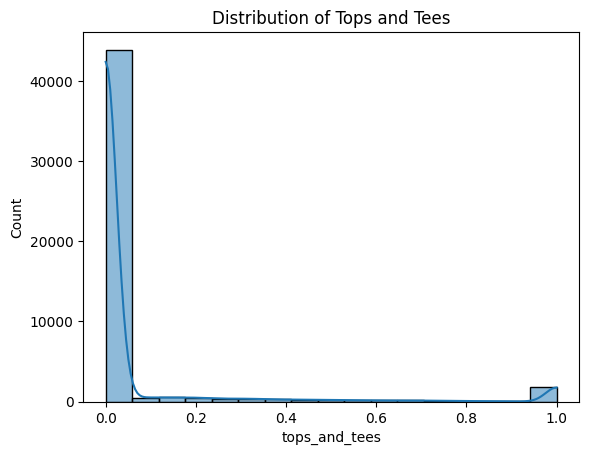

In [203]:
sns.histplot(df['tops_and_tees'], kde=True)
plt.title('Distribution of Tops and Tees')
plt.show()

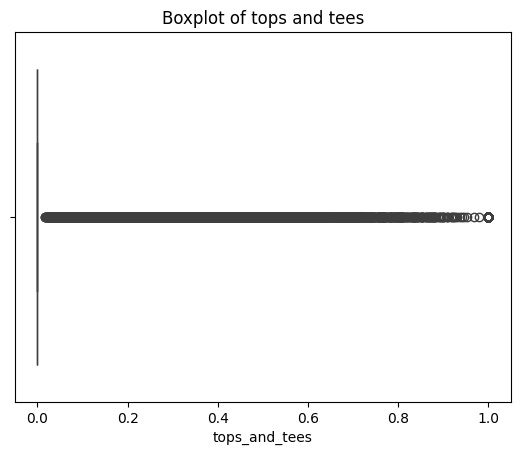

In [204]:
sns.boxplot(x=df['tops_and_tees'].sort_values(ascending=False))
plt.title('Boxplot of tops and tees')
plt.show()

In [206]:
# Correlation with other features
correlations = df[features].corr()
print(correlations['tops_and_tees'].sort_values(ascending=False))

tops_and_tees             1.000000
gender_M                  0.070445
recency                   0.003320
country_encoded           0.002786
cancelled_orders_ratio   -0.000625
returned_orders_ratio    -0.002944
customer_age             -0.002996
total_orders_completed   -0.011594
total_orders             -0.021532
socks                    -0.038267
underwear                -0.043829
total_sales_completed    -0.045144
pants                    -0.047958
dresses                  -0.051096
active                   -0.055888
accessories              -0.057591
shorts                   -0.062066
sleep                    -0.063879
swim                     -0.064678
outerwear                -0.064755
sweaters                 -0.065581
fasion_hoodies           -0.067417
intimates                -0.072976
total_sales              -0.074303
jeans                    -0.075603
other                    -0.124274
Name: tops_and_tees, dtype: float64


## Normalize Features

In [11]:
df.rename(columns={'total_sales_completed': 'monetary', 'total_orders': 'frequency'}, inplace=True)
df.head()

,customer_id,customer_tenure,recency,total_orders_completed,monetary,total_sales,frequency,returned_orders_ratio,cancelled_orders_ratio,customer_age,...,accessories,outerwear,shorts,fasion_hoodies,active,underwear,pants,socks,dresses,other
0,75990,457,844,1,19.990000,19.990000,1,0.0,0.0,35,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,77936,1,307,1,27.990000,27.990000,1,0.0,0.0,49,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0
2,86560,1,1595,2,108.200001,108.200001,1,0.0,0.0,46,...,0.0,0.0,0.0,0.0,0.399261,0.0,0.0,0.0,0.0,0.0
3,5671,360,164,1,59.990002,104.980003,2,0.0,0.5,21,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
4,4628,1,1667,1,195.300003,195.300003,1,0.0,0.0,61,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [41]:
features = [
    'frequency', 'monetary', 'recency', 'returned_orders_ratio'
]

rfm = df[features]

X = df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Determine the Optimal Number of Clusters using AIC and BIC
Steps to Determine Optimal Clusters
Prepare the Data: Ensure the data (X) is preprocessed, scaled, and ready for modeling (e.g., using StandardScaler).

Fit GMM for Multiple Cluster Counts: Iterate over a range of possible cluster counts (e.g., 1-20) and fit a GMM for each count.

Calculate AIC and BIC: For each fitted model, calculate AIC and BIC. These metrics penalize for model complexity and help you find the best tradeoff between the number of clusters and model fit.

Visualize AIC and BIC: Plot the AIC and BIC scores to visualize how they change with the number of components. The optimal cluster count corresponds to the minimum value of AIC or BIC.

In [42]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles

,frequency,monetary,recency,returned_orders_ratio
0.25,1.0,31.990000,109.0,0.0
0.50,1.0,63.990002,327.0,0.0
0.75,2.0,128.000000,727.0,0.0


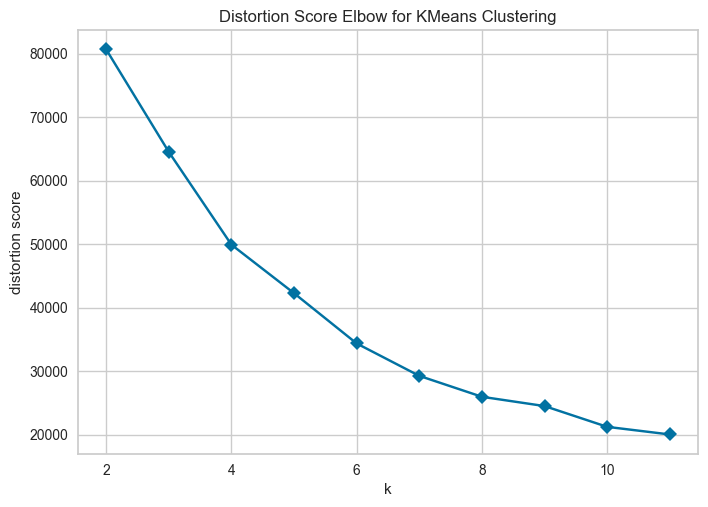

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [43]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), timings=False, locate_elbow=False)
visualizer.fit(X_scaled)  
visualizer.show()

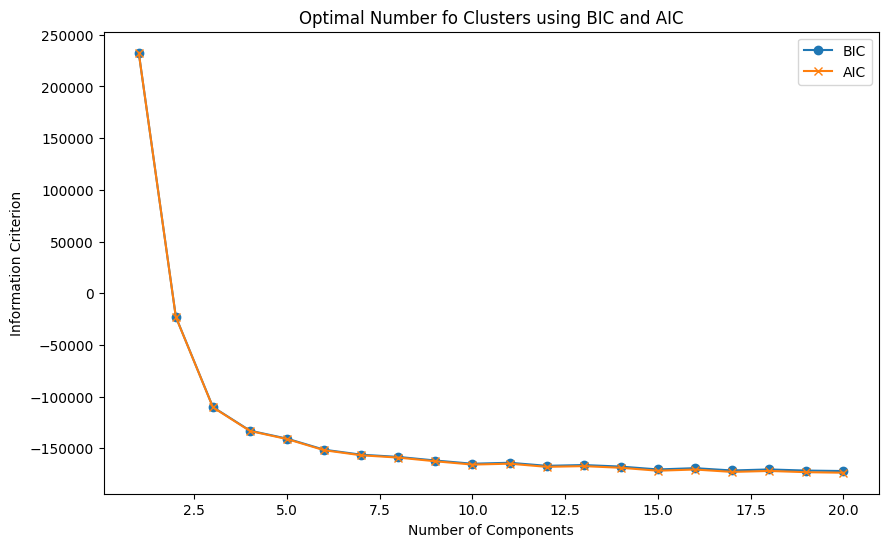

In [14]:
n_components = np.arange(1, 21) # we will test 1 - 30 clusters

models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(X_scaled) for n in n_components] #fit for each component

plt.figure(figsize=(10,6))
plt.plot(n_components, [m.bic(X_scaled) for m in models], label='BIC', marker='o')
plt.plot(n_components, [m.aic(X_scaled) for m in models], label='AIC', marker='x')
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion')
plt.legend(loc='best')
plt.title('Optimal Number fo Clusters using BIC and AIC')
plt.show()


Looking at the plot:

BIC and AIC values both decrease as the number of components (clusters) increases, which is expected.
The optimal number of clusters is typically where the curve starts to level off, which is called the "elbow point."
Observations from Your Plot
The elbow seems to occur around 10 components (where the curve starts flattening).
Beyond 10 clusters, the reduction in AIC/BIC slows down significantly, indicating diminishing returns in model complexity.

In [44]:
optimal_n = 4
gmm = GaussianMixture(n_components=optimal_n, covariance_type='full', random_state=421)
gmm.fit(X_scaled)

df['cluster_gmm'] = gmm.predict(X_scaled)

In [45]:
df.groupby('cluster_gmm').describe()

customer_id                                                      \
                  count          mean           std   min      25%      50%   
cluster_gmm                                                                   
0               18867.0  50277.302380  28833.352431   9.0  25270.0  50488.0   
1                1248.0  49620.772436  28704.109147  57.0  25131.0  49658.5   
2                2655.0  49572.461770  28739.973375  38.0  24580.0  49864.0   
3                4805.0  49446.809365  28921.040779  39.0  24651.0  49270.0   

                                customer_tenure              ...     other  \
                  75%       max           count        mean  ...       75%   
cluster_gmm                                                  ...             
0            75188.00  100000.0         18867.0  142.049133  ...  0.000000   
1            73399.25   99906.0          1248.0  538.794872  ...  0.337382   
2            74378.50   99946.0          2655.0  511.410546  ...  0.305957   
3            73973.00   99919.0          4805.0  451.552133  ...  0.292475   

                 cluster_kmeans                                               
             max          count      mean       std  min  25%  50%  75%  max  
cluster_gmm                                                                   
0            1.0        18867.0  2.374781  0.905503  1.0  1.0  3.0  3.0  3.0  
1            1.0         1248.0  0.575321  0.903934  0.0  0.0  0.0  2.0  2.0  
2            1.0         2655.0  0.186817  0.532068  0.0  0.0  0.0  0.0  2.0  
3            1.0         4805.0  0.335276  0.686626  0.0  0.0  0.0  0.0  2.0  

[4 rows x 264 columns]

In [43]:
features = ['recency', 'total_orders', 'total_sales']
df[features + ['cluster']].groupby('cluster').describe().to_csv(data_path + 'cluster_summary.csv')


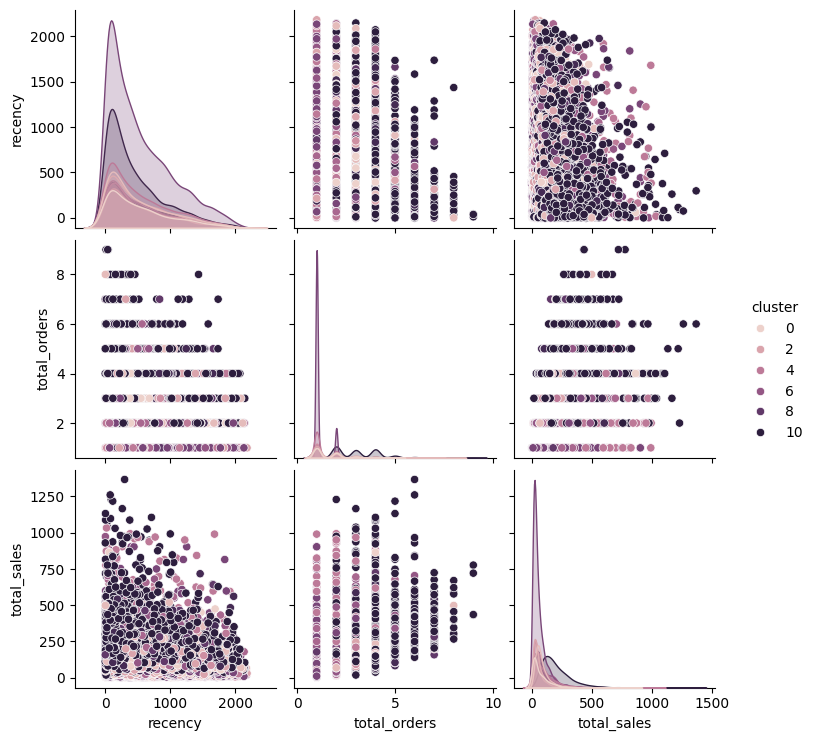

In [44]:
import seaborn as sns
sns.pairplot(df, hue='cluster', vars=['recency', 'total_orders', 'total_sales'])


<Axes: xlabel='cluster', ylabel='total_sales'>

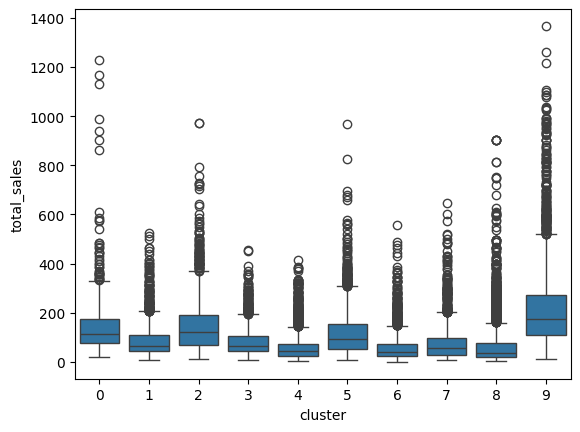

In [26]:
sns.boxplot(x='cluster', y='total_sales', data=df)



## Reduce the Dimension with PCA

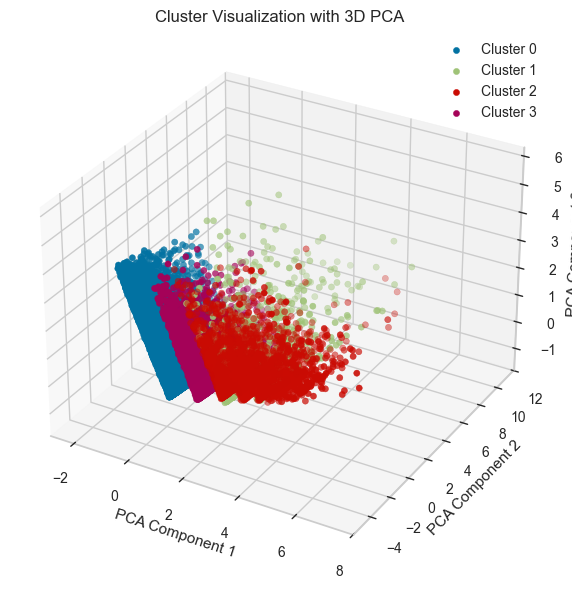

In [46]:
clusters = df['cluster_gmm'].values

# Assuming 'X' is your feature matrix and 'clusters' is the cluster labels from GMM
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for cluster in set(clusters):
    ax.scatter(
        X_pca[clusters == cluster, 0],
        X_pca[clusters == cluster, 1],
        X_pca[clusters == cluster, 2],
        label=f'Cluster {cluster}'
    )
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('Cluster Visualization with 3D PCA')
plt.legend()
plt.show()



In [60]:
# Assuming 'pca' is your PCA object and 'X_scaled' is your scaled data
pca_components = pd.DataFrame(
    pca.components_,
    columns=[f"Feature_{i}" for i in range(X_scaled.shape[1])],
    index=[f"PCA_{i+1}" for i in range(len(pca.components_))]
)
print(pca_components)


       Feature_0  Feature_1  Feature_2  Feature_3  Feature_4
PCA_1   0.696760   0.701011  -0.150374   0.015618   0.015936
PCA_2   0.015816   0.000556   0.076405   0.714525  -0.695245
PCA_3   0.035176   0.019180   0.388884   0.619753   0.680493


In [47]:
score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {score}")


Silhouette Score: 0.316234779690828


frm 4 : Silhouette Score: 0.3306274283613274


## K-Means

In [186]:
df.columns

Index(['customer_id', 'tops_and_tees', 'jeans', 'intimates', 'swim',
       'sweaters', 'sleep', 'accessories', 'outerwear', 'shorts',
       'fasion_hoodies', 'active', 'underwear', 'pants', 'socks', 'dresses',
       'other', 'total_orders_completed', 'total_sales_completed',
       'total_sales', 'total_orders', 'returned_orders_ratio',
       'cancelled_orders_ratio', 'recency', 'customer_age', 'customer_gender',
       'state', 'city', 'country', 'country_encoded', 'gender_M', 'cluster',
       'cluster_kmeans', 'kmean_cluster', 'cluster_gmm', 'dbscan_cluster'],
      dtype='object')

In [52]:
kmeans =KMeans(n_clusters=6, random_state=42)
kmeans.fit(X_scaled)
df['cluster_kmeans'] = kmeans.labels_

In [53]:
clusters = df['cluster_kmeans'].values
score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.42980486008130075


In [38]:
df.head()

,customer_id,customer_tenure,recency,total_orders_completed,monetary,total_sales,frequency,returned_orders_ratio,cancelled_orders_ratio,customer_age,...,shorts,fasion_hoodies,active,underwear,pants,socks,dresses,other,cluster_gmm,cluster_kmeans
0,75990,457,844,1,19.990000,19.990000,1,0.0,0.0,35,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3,1
1,77936,1,307,1,27.990000,27.990000,1,0.0,0.0,49,...,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,3,3
2,86560,1,1595,2,108.200001,108.200001,1,0.0,0.0,46,...,0.0,0.0,0.399261,0.0,0.0,0.0,0.0,0.0,3,1
3,5671,360,164,1,59.990002,104.980003,2,0.0,0.5,21,...,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0,0
4,4628,1,1667,1,195.300003,195.300003,1,0.0,0.0,61,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3,1


In [56]:
data_path = "/Users/amber/projects/my_customer_segmentation_project/ml-model/data/"
df.to_csv(data_path + 'data_w_clusters.csv', index=False)

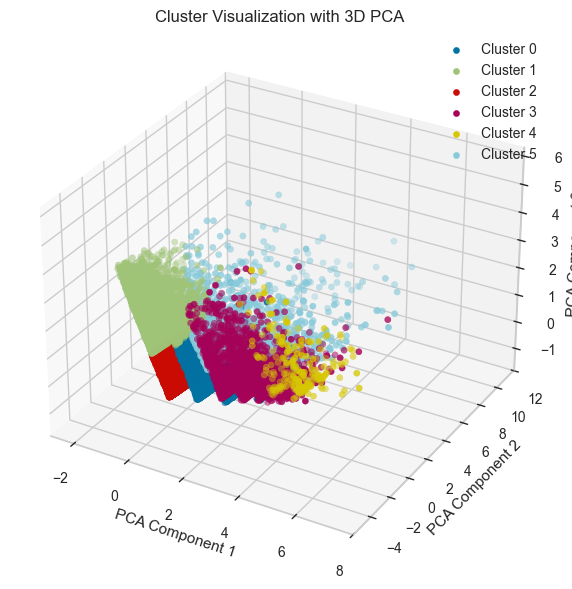

In [54]:
# Assuming 'X' is your feature matrix and 'clusters' is the cluster labels from GMM
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for cluster in set(clusters):
    ax.scatter(
        X_pca[clusters == cluster, 0],
        X_pca[clusters == cluster, 1],
        X_pca[clusters == cluster, 2],
        label=f'Cluster {cluster}'
    )
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('Cluster Visualization with 3D PCA')
plt.legend()
plt.show()

In [55]:
df.groupby('cluster_kmeans').agg({'recency':'mean',
                                  'frequency':'mean',
                                  'monetary':['mean','count'],
                                  'returned_orders_ratio': 'mean'}).round(2)

recency frequency monetary        returned_orders_ratio
                   mean      mean     mean  count                  mean
cluster_kmeans                                                         
0                268.51      2.21   100.15   4796                  0.00
1               1181.85      1.07    74.72   5909                  0.00
2                270.15      1.00    70.72  12636                  0.00
3                312.12      2.43    88.35   2348                  0.56
4                340.92      2.36    91.61    221                  1.66
5                399.18      1.61   397.15   1665                  0.02